#  Linear Regression: 4 Farklı Senaryo Analizi (R² ve MAE Metrikleri ile)

Bu çalışmada, araç fiyat tahmini için **Linear Regression** modelini 4 farklı senaryoda test edeceğiz. Modellerin başarısını iki metrikle ölçeceğiz:
1.  **R² Skoru:** Modelin veriyi ne kadar iyi açıkladığı (1'e ne kadar yakınsa o kadar iyi).
2.  **MAE (Mean Absolute Error):** Modelin tahminlerinde ortalama kaç birim (Para birimi cinsinden) hata yaptığı (Ne kadar düşükse o kadar iyi).

**Senaryolar:**
1.  **Saf Hali:** Hiçbir özellik seçimi veya ekleme yapılmadan.
2.  **Sadece Threshold:** `VarianceThreshold` ile gereksiz özellikler atılarak.
3.  **Sadece Kümeleme:** k-NN algoritması ile üretilen "Segment" bilgisi eklenerek.
4.  **Threshold + Kümeleme:** Hem gereksiz özelliklerin atıldığı hem de segment bilgisinin eklendiği hibrit model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import r2_score, mean_absolute_error # MAE eklendi

# Uyarıları kapatmak için
import warnings
warnings.filterwarnings('ignore')

### 1. Veri Yükleme ve Temizleme
Veri setini yüklüyor, temizliyor ve analiz için hazır hale getiriyoruz.

In [3]:
# Veriyi yükle
df = pd.read_csv('ekip_odevi_ham_veri_30k.csv')

# Temizleme Fonksiyonları
def clean_currency(x):
    try:
        if isinstance(x, str):
            x = x.replace('£', '').replace(',', '').strip()
            return float(x) if x and x.lower() != 'nan' else np.nan
        return float(x)
    except: return np.nan

def clean_number(x):
    try:
        if isinstance(x, str):
            x = x.replace(',', '').strip()
            return float(x) if x and x.lower() not in ['unknown', 'nan', ''] else np.nan
        return float(x)
    except: return np.nan

# Temizliği uygula
df['price_clean'] = df['price'].apply(clean_currency)
df['mileage_clean'] = df['mileage'].apply(clean_number)

# Analiz edilecek sütunları seç
features_raw = ['year', 'price_clean', 'mileage_clean', 'mpg', 'engineSize', 'marka', 'transmission', 'fuelType']
df_clean = df[features_raw].dropna().reset_index(drop=True)

# Hedef ve Özellikler
X = df_clean.drop(['price_clean'], axis=1)
y = df_clean['price_clean']

# Eğitim ve Test Ayrımı
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sütun Grupları
categorical_cols = ['marka', 'transmission', 'fuelType']
numerical_cols = ['year', 'mileage_clean', 'mpg', 'engineSize']

print("Veri hazır.")

Veri hazır.


### 2. Hazırlık: Kümeleme (k-NN) ile Yeni Özellik Üretimi
Linear Regression modelini güçlendirmek için, önce veriyi k-NN algoritması ile segmentlere ayırıyoruz. Bu segment bilgisini (Lüks mü, Ekonomik mi?) bir özellik olarak veriye ekleyeceğiz.

In [4]:
# A) Eğitim setindeki fiyatları 3 sınıfa böl
y_train_segments = pd.qcut(y_train, q=3, labels=['Ekonomik', 'Orta', 'Lüks'])

# B) k-NN Modelini Kur (Sadece Segment Tahmini İçin - Scaling Zorunlu)
knn_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

knn_model = Pipeline(steps=[
    ('preprocessor', knn_preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=15))
])

knn_model.fit(X_train, y_train_segments)

# C) Tüm veri için Segment Tahmini Yap
train_seg_pred = knn_model.predict(X_train)
test_seg_pred = knn_model.predict(X_test)

# D) Zenginleştirilmiş (Augmented) Veri Setlerini Oluştur
X_train_aug = X_train.copy()
X_test_aug = X_test.copy()
X_train_aug['Segment'] = train_seg_pred
X_test_aug['Segment'] = test_seg_pred

# Yeni kategorik sütun listesi
categorical_cols_aug = categorical_cols + ['Segment']

print("Segmentasyon tamamlandı.")

Segmentasyon tamamlandı.


### Senaryo 1: Linear Regression (Saf Hali)
* **Özellik:** Orijinal Veri
* **Threshold:** Yok
* **Kümeleme:** Yok

In [5]:
preprocessor_1 = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols), # Scaling yok
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

model_1 = Pipeline(steps=[
    ('preprocessor', preprocessor_1),
    ('regressor', LinearRegression())
])

model_1.fit(X_train, y_train)
y_pred_1 = model_1.predict(X_test)

r2_1 = r2_score(y_test, y_pred_1)
mae_1 = mean_absolute_error(y_test, y_pred_1)

print(f"Senaryo 1 -> R2: {r2_1:.4f} | MAE: {mae_1:.0f} £")

Senaryo 1 -> R2: 0.7727 | MAE: 2991 £


### Senaryo 2: Linear Regression + VarianceThreshold
* **Özellik:** Orijinal Veri
* **Threshold:** Var (0.01) -> Gereksiz özellikleri atar.
* **Kümeleme:** Yok

In [6]:
model_2 = Pipeline(steps=[
    ('preprocessor', preprocessor_1),
    ('selector', VarianceThreshold(threshold=0.01)), 
    ('regressor', LinearRegression())
])

model_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_test)

r2_2 = r2_score(y_test, y_pred_2)
mae_2 = mean_absolute_error(y_test, y_pred_2)

print(f"Senaryo 2 -> R2: {r2_2:.4f} | MAE: {mae_2:.0f} £")

Senaryo 2 -> R2: 0.7727 | MAE: 2991 £


### Senaryo 3: Linear Regression + Kümeleme
* **Özellik:** Zenginleştirilmiş Veri (Segment Dahil)
* **Threshold:** Yok
* **Kümeleme:** Var

In [7]:
preprocessor_3 = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_aug) # Segment sütunu dahil
    ])

model_3 = Pipeline(steps=[
    ('preprocessor', preprocessor_3),
    ('regressor', LinearRegression())
])

model_3.fit(X_train_aug, y_train)
y_pred_3 = model_3.predict(X_test_aug)

r2_3 = r2_score(y_test, y_pred_3)
mae_3 = mean_absolute_error(y_test, y_pred_3)

print(f"Senaryo 3 -> R2: {r2_3:.4f} | MAE: {mae_3:.0f} £")

Senaryo 3 -> R2: 0.7816 | MAE: 2856 £


### Senaryo 4: Threshold + Kümeleme
* **Özellik:** Zenginleştirilmiş Veri
* **Threshold:** Var
* **Kümeleme:** Var

In [8]:
model_4 = Pipeline(steps=[
    ('preprocessor', preprocessor_3),
    ('selector', VarianceThreshold(threshold=0.01)),
    ('regressor', LinearRegression())
])

model_4.fit(X_train_aug, y_train)
y_pred_4 = model_4.predict(X_test_aug)

r2_4 = r2_score(y_test, y_pred_4)
mae_4 = mean_absolute_error(y_test, y_pred_4)

print(f"Senaryo 4 -> R2: {r2_4:.4f} | MAE: {mae_4:.0f} £")

Senaryo 4 -> R2: 0.7816 | MAE: 2856 £


### 3. Sonuçların Karşılaştırılması
Tüm senaryoların R² ve MAE skorlarını tablo ve grafik üzerinde karşılaştırıyoruz.

                   Senaryo  R2 Skoru   MAE (Hata)
0              1) Saf Hali  0.772694  2990.871395
1      2) Sadece Threshold  0.772694  2990.871395
2       3) Sadece Kümeleme  0.781606  2856.113968
3  4) Threshold + Kümeleme  0.781606  2856.113968


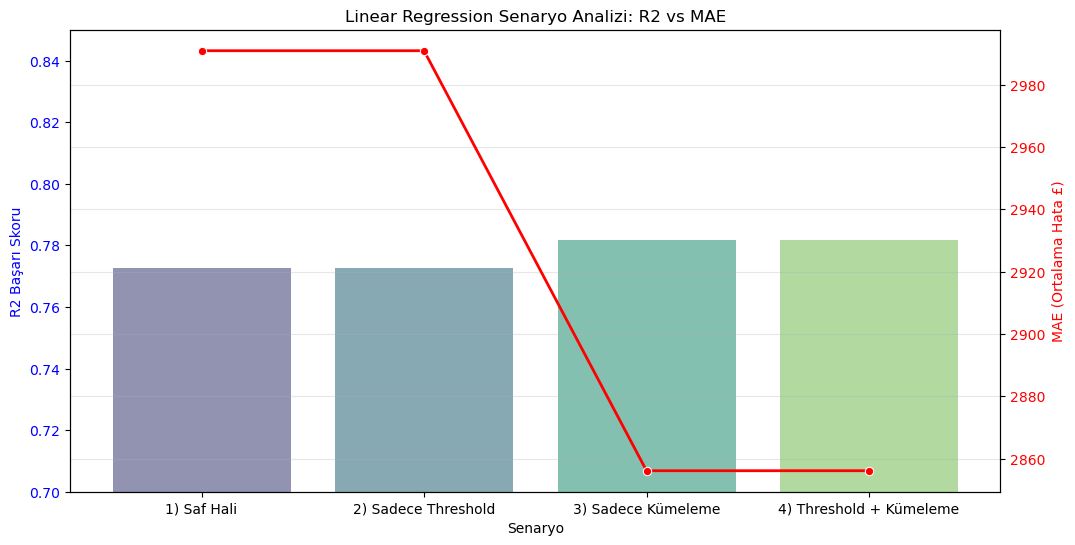

In [9]:
# Sonuç Tablosu
results = pd.DataFrame({
    'Senaryo': ['1) Saf Hali', '2) Sadece Threshold', '3) Sadece Kümeleme', '4) Threshold + Kümeleme'],
    'R2 Skoru': [r2_1, r2_2, r2_3, r2_4],
    'MAE (Hata)': [mae_1, mae_2, mae_3, mae_4]
})

print(results)

# Grafik Çizimi (İki eksenli: R2 ve MAE)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar Plot (R2 Skoru)
sns.barplot(data=results, x='Senaryo', y='R2 Skoru', ax=ax1, palette='viridis', alpha=0.6)
ax1.set_ylabel('R2 Başarı Skoru', color='blue')
ax1.set_ylim(0.70, 0.85)
ax1.tick_params(axis='y', labelcolor='blue')

# Line Plot (MAE Hatası) - Aynı grafiğe ikinci eksen olarak ekliyoruz
ax2 = ax1.twinx()
sns.lineplot(data=results, x='Senaryo', y='MAE (Hata)', ax=ax2, color='red', marker='o', linewidth=2, sort=False)
ax2.set_ylabel('MAE (Ortalama Hata £)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Linear Regression Senaryo Analizi: R2 vs MAE')
plt.grid(True, alpha=0.3)
plt.show()